In [10]:
import torch
import torch.nn as nn
import torchvision.models as models
from torchvision.models import resnet18, ResNet18_Weights
from pytorch_grad_cam import GradCAM
import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd



In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Charger ResNet18 pré-entraîné avec ImageNet
weights = ResNet18_Weights.IMAGENET1K_V1
model = resnet18(weights=weights)

# Ajout d'une première couche convolutionnelle (FC_correlation, SC_gFA, SC_density)
model.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)

# Ajout d'une dernière couche pour la classification binaire
num_ftrs = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 64),  
    nn.ReLU(),
    nn.BatchNorm1d(64),
    nn.Dropout(0.5),
    nn.Linear(64, 2)  
)

# Charger les poids entraînés
best_model_path = "Model/best_resnet18_model.pth"
model.load_state_dict(torch.load(best_model_path, map_location=device, weights_only=False))
model.to(device)
model.eval()

print("Modèle ResNet18 chargé avec les poids entraînés et prêt pour Grad-CAM.")



Modèle ResNet18 chargé avec les poids entraînés et prêt pour Grad-CAM.


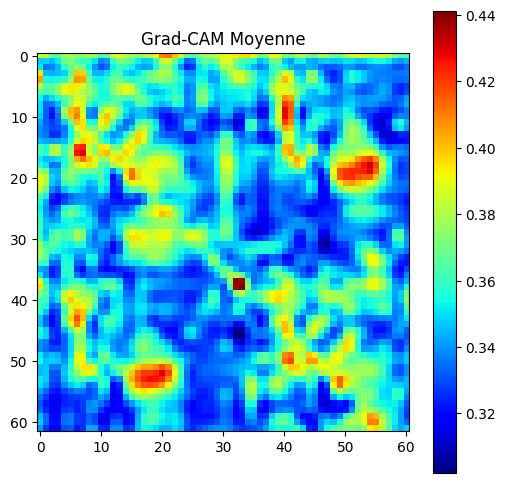

In [ ]:
# Initialiser Grad-CAM
target_layer = model.conv1  
cam = GradCAM(model=model, target_layers=[target_layer])

h5_file = 'Data_ML/SC_FC_dataset_filtered_68x68.h5'  
keys = ['FC_correlation', 'SC_gFA', 'SC_density']

with h5py.File(h5_file, 'r') as f:
    num_patients = f[keys[0]]['schz'].shape[0]  
    total_grad_cam = np.zeros((68, 68))

    for group in ['schz', 'ctrl']:  
        for patient_idx in range(num_patients):  
            # Charger les matrices du patient
            matrices_patient = np.stack([f[key][group][patient_idx] for key in keys], axis=0)  # (3, 68, 68)

            # Normalisation
            matrices_patient = (matrices_patient - matrices_patient.min()) / (matrices_patient.max() - matrices_patient.min() + 1e-8)

            # Calculer Grad-CAM moyen pour ce patient
            grad_cam_patient = np.zeros((68, 68))
            for i in range(3):  # Parcourir les 3 matrices (canaux)
                input_tensor = torch.zeros((1, 3, 68, 68), dtype=torch.float32).to(device)
                input_tensor[0, i] = torch.tensor(matrices_patient[i], dtype=torch.float32).to(device)

                grayscale_cam = cam(input_tensor=input_tensor)[0]
                grad_cam_patient += grayscale_cam  # Additionner les cartes des 3 canaux

            grad_cam_patient /= 3  # Moyenne des 3 canaux

            # Ajouter au total
            total_grad_cam += grad_cam_patient

# Moyenne sur tous les patients
total_grad_cam /= (num_patients * 2)  

plt.figure(figsize=(6,6))
plt.imshow(total_grad_cam, cmap='jet')
plt.colorbar()
plt.title("Grad-CAM Moyenne")
plt.show()


In [13]:
csv_path = "Data_ML/regions_corticales_68_indices.csv"
regions_df = pd.read_csv(csv_path)

# Renommer les colonnes 
regions_df.rename(columns={"Indice": "index", "Région Cérébrale": "region"}, inplace=True)

# Convertir l'indice en entier et ajuster pour index 0-based
regions_df["index"] = regions_df["index"].astype(int) - 1

# Charger la carte Grad-CAM moyenne 
grad_cam_array = total_grad_cam 

# Calculer la moyenne de Grad-CAM pour chaque ligne 
grad_cam_mean_per_region = grad_cam_array.mean(axis=1)

# Trouver les 10 régions avec la plus haute activation moyenne
num_top_regions = 10
top_10_regions_indices = np.argsort(grad_cam_mean_per_region)[-num_top_regions:][::-1]  

# Associer ces indices aux noms des régions corticales
top_10_regions = [regions_df.loc[i, "region"] for i in top_10_regions_indices]

# Afficher les 10 régions les plus influentes
print("Top 10 régions cérébrales les plus influentes selon Grad-CAM :")
for region in top_10_regions:
    print(region)





Top 10 régions cérébrales les plus influentes selon Grad-CAM :
rh_lateralorbitofrontal
rh_superiorparietal
rh_supramarginal
rh_inferiorparietal
rh_precuneus
lh_superiorparietal
lh_inferiorparietal
lh_supramarginal
rh_postcentral
lh_precuneus
